In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests 
import time

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

In [2]:
# all rock releases in the UK
df_masters = pd.read_csv('Datasets/df_masters.csv')
df_masters.shape

(46830, 13)

# Merge one small ``df`` with ``df_ratings``

In [197]:
# import the dataframes
df_masters_id0 = pd.read_csv('Datasets/df_masters_id0.csv')                     # all rock releases in the UK
df_ratings = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)      # all ratings, mostly from rock, worldwide

# print information
print(f'{df_masters_id0.shape}: df_masters_id0')
print(f'{df_ratings.shape}: df_ratings')

(13480, 13): df_masters_id0
(352768, 5): df_ratings


In [198]:
df_masters_id0.head(1)

,artist,title,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,Blasfeme,Black Legion,8287884.0,0,32987169,UK,2024,32.33,7,"['Album', 'Limited Edition']",['Rock'],['Black Metal'],"Blasfeme is a two piece black metal force, fue..."


## Sort columns

In [199]:
df_masters_id0.head(1)

,artist,title,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,Blasfeme,Black Legion,8287884.0,0,32987169,UK,2024,32.33,7,"['Album', 'Limited Edition']",['Rock'],['Black Metal'],"Blasfeme is a two piece black metal force, fue..."


In [200]:
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile']

In [201]:
df_masters_id0 = df_masters_id0.reindex(columns=list_of_columns)
df_masters_id0.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,8287884.0,0,32987169,UK,Blasfeme,Black Legion,2024,32.33,7,"['Album', 'Limited Edition']",['Rock'],['Black Metal'],"Blasfeme is a two piece black metal force, fue..."


## Cleaning

I noticed some artist and/or album names are slightly different, which will cause the merge to not properly function as I intend it.

In [202]:
df_masters_id0[['artist', 'title']] = df_masters_id0[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))
df_ratings[['artist', 'title']] = df_ratings[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))

## Actual merge

In [253]:
df_masters_id0_ratings = pd.merge(
    df_ratings.assign(artist_lower=df_ratings['artist'].str.lower().str.strip(), 
                      title_lower=df_ratings['title'].str.lower().str.strip()), 
    df_masters_id0.assign(artist_lower=df_masters_id0['artist'].str.lower().str.strip(), 
                      title_lower=df_masters_id0['title'].str.lower().str.strip()), 
    on=['artist_lower', 'title_lower']
).drop(columns=['artist_lower', 'title_lower', 'artist_y', 'title_y'])

# Rename columns
df_masters_id0_ratings.rename(columns={'artist_x': 'artist', 'title_x': 'title'}, inplace=True)

# Change dtypes
df_masters_id0_ratings['master_id'] = df_masters_id0_ratings['master_id'].astype(int)

# print the shape
df_masters_id0_ratings.shape

(703, 16)

In [254]:
print(f"Only {round(df_masters_id0.shape[0] / df_masters.shape[0]*100, 2)} % of the albums have ratings")

Only 28.78 % of the albums have ratings


**I keep only the albums that have at least 10 votes**

In [255]:
# how many of them have at least 10 votes?
df = df_masters_id0_ratings[df_masters_id0_ratings['votes']>=10]
df.shape

(203, 16)

**I keep only rock albums**

In [256]:
# how many of them are Rock albums?
df = df[df['genres'].str.contains('Rock')]
df.shape

(203, 16)

**Drop compilations**

In [257]:
df = df[~df['release_type'].str.contains('Compilation')]
df.shape

(200, 16)

In [258]:
# number of unique artists
df['artist'].nunique()

178

## Concat with the albums previously cleaned

In [259]:
df_masters_ratings_uk = pd.read_csv('Datasets/df_masters_ratings_uk.csv')         # df with the albums already cleaned
df_masters_ratings_uk.shape

(9918, 13)

In [264]:
df_masters_ratings_uk.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,253712,158153,426893,US,Sparta,Wiretap Scars,2002,47.62,12,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte..."


**Sort columns**

In [263]:
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile']

In [265]:
df = df.reindex(columns=list_of_columns)
df.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,261436.0,0,13477274,UK,Lostprophets,Start Something,2006,0.0,13,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Alternative Rock', 'Nu Metal']",Alternative Rock / Modern Rock band from Ponty...


In [266]:
df_concat = pd.concat([df_masters_ratings_uk, df])
df_concat.shape

(10118, 13)

## ``df_masters_ratings`` cleaning

I want to **drop duplicates** and releases from **bands outside of the UK**, I only want to keep brittish artists. Also **drop compilations and live albums**.

In [267]:
df[['artist', 'title']].duplicated().sum()

1

In [268]:
df[df[['artist', 'title']].duplicated()].tail()

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
331,6516.0,0,18745387,UK,My Bloody Valentine,m b v,2013,46.62,9,['Album'],"['Rock', 'Pop']",['Shoegaze'],My Bloody Valentine are an Irish-English rock ...


In [91]:
df[df['artist']=='My Bloody Valentine'].sort_values('year')

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
330,121604,My Bloody Valentine,m b v,2013,3.79,1548,46.62,9,UK,"['LP', 'Album']",['Rock'],['Shoegaze'],NaN,NaN,0,4259634
331,121604,My Bloody Valentine,m b v,2013,3.79,1548,46.62,9,UK,['Album'],"['Rock', 'Pop']",['Shoegaze'],My Bloody Valentine are an Irish-English rock ...,6516.0,0,18745387


In [ ]:
df[df['title']=='MyValentine'].sort_values('year')

In [ ]:
# check one by one if necessary
try:
    df.drop([256], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(10054, 16)


In [ ]:
# df.loc[4736, 'title'] = 'The Butterfly Album'
# df.loc[4736, 'rating'] = 3.65
# df.loc[4736, 'votes'] = 27
# df.loc[1990, 'album_length'] = 43.43
# df.loc[4737, 'tracks'] = 10

In [ ]:
26/60

0.43333333333333335

**Deleting artists from outside the UK**

While checking online for these duplicated albums, I can see the country of origin, and if it's not the UK I drop directly these bands

In [92]:
df.artist = np.where(df['artist']=='My Bloody Valentine', np.nan, df['artist'])

df.dropna(subset=['artist'], inplace=True)

In [94]:
# number of unique artists, before there were 178
df['artist'].nunique()

177

### **Drop live albums**

Let's try to detect the live albums by the title

**'Live at'**

In [95]:
df.shape

(198, 16)

In [96]:
print(f"There are {df[df['title'].str.contains('Live at')].shape[0]} albums with 'Live at' in the title")

There are 0 albums with 'Live at' in the title


In [97]:
# Let's check them before deleting them
df[df['title'].str.contains('Live at')]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [98]:
# correct, they are all live albums
df = df[~df['title'].str.contains('Live at')]
df.shape

(198, 16)

**'Live in'**

In [99]:
print(f"There are {df[df['title'].str.contains('Live in')].shape[0]} albums with 'Live in' in the title")

There are 0 albums with 'Live in' in the title


In [100]:
# Let's check them before deleting them
df[df['title'].str.contains('Live in')]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [ ]:
# I can drop them all
df = df[~df['title'].str.contains('Live in')]
df.shape

(198, 16)

### **Dropping compilations sorting albums by the top rated**

Usually compilations have the best songs of the band and users love them, so let's find them, even if 'Compilation' is not in ``release_type``

In [102]:
start_row = 0

df.sort_values(['rating', 'votes'], ascending=False).iloc[start_row:start_row+10]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
1,185,Pink Floyd,Animals,2014,4.51,5420,41.52,5,UK,"['LP', 'Album', 'Unofficial Release', 'Stereo']",['Rock'],['Prog Rock'],Pink Floyd was an English rock band from Londo...,45467.0,0,7139102
7,871,Nick Drake,Pink Moon,2009,4.46,2173,0.00,11,UK,"['LP', 'Album', 'Reissue']","['Rock', 'Folk, World, & Country']","['Folk', 'Acoustic', 'Folk Rock']",British folk singer-songwriter and guitarist (...,28085.0,0,1994905
17,2261,Howards Alias,The Answer Is Never,2004,4.45,11,0.00,16,UK,['Album'],"['Rock', 'Reggae']","['Punk', 'Ska', 'Indie Rock']","Band in the modern UK underground punk scene, ...",918301.0,0,6478802
2,479,Neutral Milk Hotel,In the Aeroplane Over the Sea,2005,4.38,4961,0.00,11,UK,"['Album', 'Promo']",['Rock'],"['Alternative Rock', 'Lo-Fi', 'Indie Rock']",NaN,252434.0,0,4712858
25,4044,Howards Alias,"Beat Heart, Beat",2005,4.38,13,0.00,13,UK,['Album'],['Rock'],['Punk'],"Band in the modern UK underground punk scene, ...",918301.0,0,3601428
220,80367,Enter Shikari,Live From Planet Earth,2011,4.29,35,0.00,21,UK & Europe,['Album'],"['Electronic', 'Rock']",['Hardcore'],NaN,NaN,0,2985898
61,21932,Bon Iver,"For Emma, Forever Ago",2011,4.25,3551,37.18,9,UK,"['LP', 'Album']","['Rock', 'Folk, World, & Country']","['Folk Rock', 'Acoustic', 'Indie Rock', 'Folk']",American indie folk band started 2007 as a sol...,1042739.0,0,4968048
3,635,The Doors,Strange Days,2006,4.22,1372,0.00,12,UK & Europe,"['HDCD', 'Album', 'Remastered']",['Rock'],[],American psychedelic rock/blues rock band form...,56798.0,0,13686687
18,2419,Cult of Luna,Salvation,2004,4.21,1162,73.88,8,UK,['Album'],['Rock'],"['Sludge Metal', 'Hardcore', 'Post Rock', 'Exp...",Swedish metal band with members from Luleå and...,260046.0,0,8361591
16,1890,Queen,Queen II,2015,4.17,1080,0.00,13,UK & Europe,"['LP', 'Single Sided', 'Album', 'Etched', 'Rei...",['Rock'],"['Hard Rock', 'Arena Rock', 'Glam']",Queen is a British rock band formed in London ...,81013.0,0,28175128


In [ ]:
df.shape

(10044, 16)

In [ ]:
# check one by one if necessary
try:
    df.drop([6441], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Couldn't drop these rows
(9927, 16)


While checking online for these duplicated albums, I can see the country of origin, and if it's not the UK I drop directly these bands

In [ ]:
df.artist = np.where(df['artist']=='Megadeth', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Enslaved', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Thin Lizzy', np.nan, df['artist'])
df.artist = np.where(df['artist']=='The Lucksmiths', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Opeth', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Talking Heads', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Rory Gallagher', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Pearl Jam', np.nan, df['artist'])

df.artist = np.where(df['artist']=='The Doors', np.nan, df['artist'])
df.artist = np.where(df['artist']=='The Beach Boys', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Metallica', np.nan, df['artist'])

df.dropna(subset=['artist'], inplace=True)

In [ ]:
# number of unique artists, before there were 4197
df['artist'].nunique()

4173

### **Export to csv**

In [ ]:
df.to_csv('Datasets/df_uk_rock_ratings.csv', index=False)

In [ ]:
df.shape

In [ ]:
df.drop(columns=['album_id', 'artist', 'title'], inplace=True)
df.shape

(9927, 13)

In [ ]:
df.to_csv('Datasets/df_masters_ratings_uk.csv', index=False)

# **1. Merge ``df_masters`` & ``df_ratings``**

In [129]:
# import the dataframes
df_masters = pd.read_csv('Datasets/df_masters.csv')                         # all rock releases in the UK
df_uk_rock_ratings = pd.read_csv('Datasets/df_uk_rock_ratings.csv')         # df with the albums already cleaned
df_ratings_top = pd.read_csv('Datasets/df_ratings_top.csv', keep_default_na=False)  # all ratings, mostly from rock, worldwide

# print information
print(f'{df_masters.shape}: df_masters')
print(f'{df_uk_rock_ratings.shape}: df_uk_rock_ratings')
print(f'{df_ratings_top.shape}: df_ratings_top')

(46830, 13): df_masters
(10044, 16): df_uk_rock_ratings
(79632, 5): df_ratings_top


In [101]:
df_ratings_top.head(1)

,album_id,artist,title,rating,votes
0,37,Less Than Jake,Losing Streak,3.9,414


In [ ]:
df_masters.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,9204100,3600509,31708550,UK,Dukes Of Tijuana,"Tough Love, Taboos & Tattoos",2024,0.0,12,['Album'],['Rock'],"['Psychobilly', 'Rockabilly']",Neo-Rockabilly band from Germany.


## **``df_masters`` parenthesis cleaning from ``artist``**

### Testing

I noticed that some artists in df_masters (so, in the Discogs API) have numbers in parenthesis in the artist name, which won't be merged with df_ratings, where there are almost no artists with numbers in parenthesis

In [ ]:
# all the artists in df_masters
df_masters['artist'].nunique()

23134

In [ ]:
# show the artists that have characters in parenthesis in the artist name
df_masters_parenthesis = df_masters[df_masters['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_masters_parenthesis['artist'].nunique()

3995

In [100]:
# print information
print(f'{df_masters.shape}: df_masters')
print(f'{df_masters_parenthesis.shape}: df_masters_parenthesis')

(46830, 13): df_masters
(6833, 13): df_masters_parenthesis


In [ ]:
df_ratings_top['artist'].nunique()

23855

In [ ]:
# show the artists that have characters in parenthesis in the artist name
df_ratings_top_parenthesis = df_ratings_top[df_ratings_top['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_ratings_top_parenthesis['artist'].nunique()

701

In [102]:
# print information
print(f'{df_ratings_top.shape}: df_ratings_top')
print(f'{df_ratings_top_parenthesis.shape}: df_ratings_top_parenthesis')

(79632, 5): df_ratings_top
(1760, 5): df_ratings_top_parenthesis


In [106]:
df_ratings_top_parenthesis.sample(5)

,album_id,artist,title,rating,votes
45462,114771,Acrania (MEX),An Uncertain Collision,3.77,13
53530,167892,Soundtrack (Film),Shrek 2,3.82,14
26340,45676,Gehenna (USA),Upon the Gravehill,3.58,12
21658,35765,Various Artists (Indie),Dark Was The Night,3.99,104
56648,193509,Entrails (SWE),Obliteration,2.96,30


In most of the artists, the information between parenthesis is the country of origin

In [ ]:
# delete these characters
df_masters_parenthesis_clean = df_masters_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_masters_parenthesis_clean

19715              "O"
21160            P. E.
23496            P. E.
31965         NoW_NAME
30328    Six. By Seven
             ...      
4017         the dread
33209              uhr
36001              zio
33102             ĠENN
350            Батюшка
Name: artist, Length: 6833, dtype: object

In [111]:
# delete these characters
df_ratings_top_parenthesis_clean = df_ratings_top_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_ratings_top_parenthesis_clean

52533                  
53599                  
35534    Slowest Runner
35487    Slowest Runner
13266              p.e.
              ...      
39716              hide
68464              life
70926              life
49438              sway
68857              オオハシ
Name: artist, Length: 1760, dtype: object

In [ ]:
# merge test, all the artists that coincide on both dataframes after the parenthesis cleaning
pd.merge(df_masters_parenthesis_clean, df_ratings_top_parenthesis_clean, on='artist')

,artist
0,Abandon
1,Abandon
2,Abandon
3,Abandon
4,Abduction
...,...
1671,X
1672,X
1673,Zebra
1674,Zebra


In [119]:
df_masters[df_masters['artist'].str.contains('Zebra ')]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
25630,1770053,608721,8203178,"USA, Canada & UK",Zebra Tracks,Collective Guilt,2012,34.77,9,"['FLAC', 'MP3', 'WAV', 'Album']","['Rock', 'Pop']","['Indie Pop', 'Alternative Rock']",NaN
27033,869107,232322,1131982,US,Zebra (8),Zebra,1983,37.50,9,"['LP', 'Album']",['Rock'],"['Hard Rock', 'Prog Rock']","An American hard rock trio, formed in 1975 in ..."
27038,869107,232318,1630479,US,Zebra (8),No Tellin' Lies,1984,39.08,10,"['LP', 'Album']",['Rock'],['Hard Rock'],"An American hard rock trio, formed in 1975 in ..."
42088,869107,232320,1916701,Europe,Zebra (8),3.V,1986,39.90,10,"['LP', 'Album']",['Rock'],"['Hard Rock', 'Arena Rock']","An American hard rock trio, formed in 1975 in ..."


In [118]:
df_ratings_top[df_ratings_top['artist'].str.contains('Zebra ')]

,album_id,artist,title,rating,votes
4962,7456,Zebra (US),Zebra,3.88,20
41064,92943,Zebra Katz,Ima Read,2.80,10
48159,130652,Zebra Katz,DRKLNG,3.18,11
70515,345135,Zebra Katz,Less Is Moor,3.75,20


This shows that for instance **the artist 'Zebra' would not have merged** if we hadn't done that cleaning, because in ``df_masters`` it's registered under **"Zebra (8)"**, and in ``df_ratings`` under **"Zebra (US)"**

### **Let's change the ``artist`` column for good**

In [132]:
df_masters['artist'] = df_masters['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"Before we had 23134 unique artists, now we have {df_masters['artist'].nunique()}")

Before we had 23134 unique artists, now we have 22827


In [131]:
df_ratings_top['artist'] = df_ratings_top['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"Before we had 23855 unique artists, now we have {df_ratings_top['artist'].nunique()}")

Before we had 23855 unique artists, now we have 23683


## Sort columns

In [133]:
df_masters.columns

Index(['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile'],
      dtype='object')

In [134]:
df_masters.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,9204100,3600509,31708550,UK,Dukes Of Tijuana,"Tough Love, Taboos & Tattoos",2024,0.0,12,['Album'],['Rock'],"['Psychobilly', 'Rockabilly']",Neo-Rockabilly band from Germany.


In [150]:
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile']

In [151]:
df_uk_rock_ratings = df_uk_rock_ratings.reindex(columns=list_of_columns)
df_uk_rock_ratings.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,253712,158153,426893,US,Sparta,Wiretap Scars,2002,47.62,12,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte..."


In [ ]:
# df_masters.to_csv('Datasets/df_masters.csv', index=False)

## &/and Cleaning

I noticed some artist and/or album names are slightly different, which will cause the merge to not properly function as I intend it.

Notice the difference in the following album: "Behold **and/&** See"

In [137]:
df_ratings_top[df_ratings_top['artist']=="Ultimate Spinach"]

,album_id,artist,title,rating,votes
48957,136113,Ultimate Spinach,Ultimate Spinach,3.81,27
51045,150508,Ultimate Spinach,Behold and See,3.89,23


In [138]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
9274,407733,292196,1382596,US,Ultimate Spinach,Ultimate Spinach,1969,37.83,10,"['LP', 'Album']",['Rock'],['Psychedelic Rock'],"American Psychedelic Rock Band from Boston, Ma..."
9886,407733,124122,1972400,US,Ultimate Spinach,Ultimate Spinach,1968,36.28,9,"['LP', 'Album', 'Stereo']",['Rock'],"['Psychedelic Rock', 'Garage Rock']","American Psychedelic Rock Band from Boston, Ma..."
23062,407733,124123,1922050,US,Ultimate Spinach,Behold & See,1968,52.07,8,"['LP', 'Album', 'Stereo']",['Rock'],['Psychedelic Rock'],"American Psychedelic Rock Band from Boston, Ma..."


In [139]:
df_masters[['artist', 'title']] = df_masters[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))
df_ratings[['artist', 'title']] = df_ratings[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))

In [140]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
9274,407733,292196,1382596,US,Ultimate Spinach,Ultimate Spinach,1969,37.83,10,"['LP', 'Album']",['Rock'],['Psychedelic Rock'],"American Psychedelic Rock Band from Boston, Ma..."
9886,407733,124122,1972400,US,Ultimate Spinach,Ultimate Spinach,1968,36.28,9,"['LP', 'Album', 'Stereo']",['Rock'],"['Psychedelic Rock', 'Garage Rock']","American Psychedelic Rock Band from Boston, Ma..."
23062,407733,124123,1922050,US,Ultimate Spinach,Behold and See,1968,52.07,8,"['LP', 'Album', 'Stereo']",['Rock'],['Psychedelic Rock'],"American Psychedelic Rock Band from Boston, Ma..."


## Actual merge

In [ ]:
df = pd.merge(
    df_ratings_top.assign(artist_lower=df_ratings_top['artist'].str.lower().str.strip(), 
                      title_lower=df_ratings_top['title'].str.lower().str.strip()), 
    df_masters.assign(artist_lower=df_masters['artist'].str.lower().str.strip(), 
                      title_lower=df_masters['title'].str.lower().str.strip()), 
    on=['artist_lower', 'title_lower']
).drop(columns=['artist_lower', 'title_lower', 'artist_y', 'title_y'])

# Rename columns
df.rename(columns={'artist_x': 'artist', 'title_x': 'title'}, inplace=True)

# Change dtypes
df['master_id'] = df['master_id'].astype(int)

# print the shape
df.shape

(11896, 16)

In [146]:
df.head(1)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,40,Sparta,Wiretap Scars,3.79,431,253712,158153,426893,US,2002,47.62,12,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte..."


In [147]:
print(f"Only {round(df.shape[0] / df_masters.shape[0]*100, 2)} % of the albums have ratings")

Only 25.4 % of the albums have ratings


### First inspection

**Sort columns**

I want to see the ``year`` next to the album ``title``, and I don't care much about the ``ids``

In [148]:
df.columns

Index(['album_id', 'artist', 'title', 'rating', 'votes', 'artist_id',
       'master_id', 'main_release_id', 'release_country', 'year',
       'album_length', 'tracks', 'release_type', 'genres', 'styles',
       'artist_profile'],
      dtype='object')

In [149]:
list_of_columns = ['album_id', 'artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks', 'release_country',
       'release_type', 'genres', 'styles', 'artist_profile', 'artist_id', 'master_id', 'main_release_id']

In [ ]:
df = df.reindex(columns=list_of_columns)
df.head(1)

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
0,40,Sparta,Wiretap Scars,2002,3.79,431,47.62,12,US,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte...",253712,158153,426893


**I keep only rock albums**

In [152]:
# how many of them are Rock albums?
df = df[df['genres'].str.contains('Rock')]
df.shape

(11620, 16)

**Drop compilations**

In [ ]:
df['release_type'].isna().sum()

1

In [157]:
df[df['release_type'].isna()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
6987,75222,Fireworks,Gospel,2011,3.85,331,0.0,12,US,NaN,['Rock'],"['Punk', 'Pop Rock']","American pop-punk band from Metro Detroit, Mic...",1922447,378800,4088584


In [158]:
# it's an american band, so I can just drop it
df.drop(6987, inplace=True)
df['release_type'].isna().sum()

0

In [159]:
df = df[~df['release_type'].str.contains('Compilation')]
df.shape

(11563, 16)

In [160]:
# number of unique artists
df['artist'].nunique()

4943

## ``df`` real cleaning

I want to **drop duplicates** and releases from **bands outside of the UK**, I only want to keep brittish artists. Also **drop compilations and live albums**.

### Drop duplicates

In [353]:
df[['artist', 'title']].duplicated().sum()

0

In [354]:
# check one by one
df[df[['artist', 'title']].duplicated()].tail()

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [350]:
# to see the difference between the duplicated albums searching for the artist
df[df['artist']=='Quiet Riot'].sort_values('year')

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [351]:
# to see the difference between the duplicated albums searching for the album name
df[df['title']=='Imagine'].sort_values('year')

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
268,769,John Lennon,Imagine,1971,3.9,580,38.5,10,UK,"['LP', 'Album', 'Stereo']",['Rock'],['Pop Rock'],"Songwriter, rock singer and guitar player, bes...",46481,72879,382877


In [325]:
# check the original info of the rating
df_ratings_top[df_ratings_top['artist']=='The House of Love']

,album_id,artist,title,rating,votes
19419,31258,The House of Love,The House Of Love,3.70,30
19420,31259,The House of Love,The House Of Love [1990],3.65,27


In [ ]:
# initial shape to compare it after the duplicated albums drop
df.shape

(11562, 16)

In [348]:
# check one by one if necessary
try:
    df.drop([267], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(11463, 16)


In [322]:
# change specific values that are wrong/missing

df.loc[4701, 'title'] = 'The Butterfly Album'
df.loc[4701, 'rating'] = 3.65
df.loc[4701, 'votes'] = 27
df.loc[2084, 'album_length'] = 43.43
df.loc[4702, 'tracks'] = 10

In [321]:
# calculate the decimals of the album length (seconds)
26/60

0.43333333333333335

**Deleting artists from outside the UK**

While checking online for these duplicated albums, I can see the country of origin, and if it's not the UK I drop directly these bands

In [352]:
df.artist = np.where(df['artist']=='Evanescence', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Stake', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Embrace', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Ultimate Spinach', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Jeff Buckley', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Four Year Strong', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Todd Rundgren', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Lunatic Soul', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Throwing Muses', np.nan, df['artist'])
df.artist = np.where(df['artist']=='The Cramps', np.nan, df['artist'])
df.artist = np.where(df['artist']=='American Football', np.nan, df['artist'])
df.artist = np.where(df['artist']=='MD.45', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Quiet Riot', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Red House Painters', np.nan, df['artist'])
df.artist = np.where(df['artist']=='The Bronx', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Weezer', np.nan, df['artist'])

df.dropna(subset=['artist'], inplace=True)

In [355]:
# number of unique artists, before there were 4943
df['artist'].nunique()

4927

### **Drop live albums**

Let's try to detect the live albums by the title

**'Live at'**

In [356]:
df.shape

(11453, 16)

In [ ]:
print(f"There are {df[df['title'].str.contains('Live at ', case=False)].shape[0]} albums with 'Live at ' in the title")

There are 0 albums with 'Live at' in the title


In [ ]:
# Let's check them before deleting them
df[df['title'].str.contains('Live at ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
793,2763,Ozzy Osbourne,Live At Budokan,2002,3.61,94,66.52,13,Europe,['Album'],['Rock'],"['Hard Rock', 'Heavy Metal']","John Michael Osbourne, professionally known as...",59770,206003,2745991
4394,28660,The Fall,Live At The Witch Trials,1979,3.77,156,38.65,11,UK,"['LP', 'Album']",['Rock'],"['New Wave', 'Post-Punk']","Post-punk band from Greater Manchester, UK. 19...",2228,38998,372000
6761,69389,At the Gates,Purgatory Unleashed: Live At Wacken,2010,4.31,54,73.00,18,Europe,"['Album', 'Limited Edition']",['Rock'],['Death Metal'],"A death metal band from Gothenburg, Sweden, fo...",269173,236417,2650627
6882,72449,Iron Maiden,Live At The Rainbow,1981,4.22,38,0.00,7,UK,"['Stereo', 'PAL']",['Rock'],['Heavy Metal'],"English heavy metal band formed in Leyton, Eas...",251595,435450,2181680
7125,79170,Biffy Clyro,Revolutions // Live At Wembley,2011,3.99,60,103.65,53,UK,['Album'],['Rock'],"['Power Pop', 'Indie Rock']",Biffy Clyro are a mainstream rock band which f...,269159,350353,2965167
8318,128527,The Jimi Hendrix Experience,Live At Winterland,1987,4.67,15,67.72,13,UK,"['LP', 'Album', 'Stereo']",['Rock'],"['Blues Rock', 'Psychedelic Rock']",The Jimi Hendrix Experience (often shortened t...,255672,24707,4572380
9813,236884,Enter Shikari,Live At Alexandra Palace,2016,4.19,16,0.00,16,UK,"['LP', 'Album']","['Electronic', 'Rock']","['Alternative Rock', 'Hardcore']",Enter Shikari are an English four-piece rock b...,652888,1096780,9381289
10748,341452,IDLES,A Beautiful Thing: Idles Live At Le Bataclan,2019,4.15,24,0.00,21,Worldwide,['Album'],['Rock'],"['Punk', 'Post-Punk']","British heavy indie/punk band from Bristol, Lo...",2890530,1645355,14475294


In [ ]:
# correct, they are all live albums
df = df[~df['title'].str.contains('Live at ', case=False)]
df.shape

(11425, 16)

**'Live in'**

In [ ]:
print(f"There are {df[df['title'].str.contains('Live in ', case=False)].shape[0]} albums with 'Live in ' in the title")

There are 12 albums with 'Live in' in the title


In [381]:
# Let's check them before deleting them
df[df['title'].str.contains(r'^Live in ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [379]:
# I can drop them all
df = df[~df['title'].str.contains(r'^Live in ', case=False)]
df.shape

(11415, 16)

In [ ]:
# This is a studio album
df[df['title'].str.contains('Live in ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
10195,274989,IAMX,Alive In New Light,2018,3.42,12,40.13,9,UK & Europe,['Album'],"['Electronic', 'Rock']","['Alternative Rock', 'Electro']",IAMX is the solo musical project of [a209168] ...,192242,1318851,11504248


### **Dropping compilations sorting albums by the top rated**

Usually compilations have the best songs of the band and users love them, so let's find them, even if 'Compilation' is not in ``release_type``

In [410]:
start_row = 20

df.sort_values(['rating', 'votes'], ascending=False).iloc[start_row:start_row+10]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
981,3655,Jethro Tull,Thick as a Brick,1972,4.45,1313,43.92,2,UK,"['LP', 'Album', 'Stereo']",['Rock'],"['Classic Rock', 'Prog Rock']",Jethro Tull is a Grammy Award winning British ...,30122,38308,3858813
6276,58822,The Aliens,Luna,2008,4.45,10,66.13,13,UK,['Album'],"['Electronic', 'Rock']","['Leftfield', 'Psychedelic Rock']",Scottish band formed when [a=The Beta Band] sp...,510443,175371,1636587
2463,11614,The Beatles,Sgt. Pepper's Lonely Hearts Club Band,1967,4.44,4735,39.02,13,UK,"['LP', 'Album', 'Mono']","['Rock', 'Pop']","['Rock & Roll', 'Psychedelic Rock', 'Pop Rock']","Emerging from Liverpool, England in 1960, the ...",82730,23934,499497
95,286,The Clash,London Calling,1979,4.44,2827,63.98,19,UK,"['LP', 'Album', 'Stereo']",['Rock'],"['Punk', 'New Wave']",Influential British punk rock group from west ...,29890,19382,470912
1216,5134,Kate Bush,Hounds of Love,1985,4.44,1435,46.90,14,UK,"['LP', 'Album', 'Stereo']","['Electronic', 'Rock', 'Pop']","['Art Rock', 'Experimental', 'Pop Rock']","Highly distinctive singer/songwriter, born Jul...",85929,28680,197163
1421,5987,Camel,Mirage,1974,4.44,1399,38.37,5,UK,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],English progressive rock group formed in 1971 ...,140646,33559,619057
74,226,Radiohead,Kid A,2000,4.43,7685,46.72,15,UK,"['10""', '33 ⅓ RPM', 'Album', 'Stereo']","['Electronic', 'Rock']","['Alternative Rock', 'IDM', 'Experimental']",Electronic and alternative rock (modern rock) ...,3840,21501,74743
1065,4049,David Bowie,Low,1977,4.43,2011,0.00,11,UK,"['LP', 'Album', 'Stereo']","['Electronic', 'Rock']","['Art Rock', 'Ambient', 'Experimental']","British pop/rock singer, musician, songwriter,...",10263,22382,216166
739,2569,Talk Talk,Laughing Stock,1991,4.43,1449,0.00,6,UK,"['LP', 'Album', 'Stereo']",['Rock'],"['Post Rock', 'Experimental', 'Ambient']",British synth pop / art rock band founded in 1...,60480,26553,152255
72,221,Iron Maiden,The Number Of The Beast,1982,4.42,4682,39.18,8,UK,"['LP', 'Album', 'Stereo']",['Rock'],['Heavy Metal'],"English heavy metal band formed in Leyton, Eas...",251595,18742,1466299


In [402]:
# check one by one if necessary
try:
    df.drop([6598], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(11269, 16)


While checking online for these duplicated albums, I can see the country of origin, and if it's not the UK I drop directly these bands

In [ ]:
df.artist = np.where(df['artist']=='Megadeth', np.nan, df['artist'])
df.artist = np.where(df['artist']=='The Band', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Enslaved', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Thin Lizzy', np.nan, df['artist'])
df.artist = np.where(df['artist']=='The Lucksmiths', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Opeth', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Talking Heads', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Rory Gallagher', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Pearl Jam', np.nan, df['artist'])
df.artist = np.where(df['artist']=='My Bloody Valentine', np.nan, df['artist'])
df.artist = np.where(df['artist']=='The Doors', np.nan, df['artist'])
df.artist = np.where(df['artist']=='The Beach Boys', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Metallica', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Death', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Bob Dylan', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Tom Waits', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Tool', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Brand New', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Alice in Chains', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Nine Inch Nails', np.nan, df['artist'])
df.artist = np.where(df['artist']=='Rush', np.nan, df['artist'])

df.dropna(subset=['artist'], inplace=True)

In [411]:
# number of unique artists, before there were 4927
df['artist'].nunique()

4905

### **Sort columns**

In [192]:
df_masters.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,9204100,3600509,31708550,UK,Dukes Of Tijuana,"Tough Love, Taboos and Tattoos",2024,0.0,12,['Album'],['Rock'],"['Psychobilly', 'Rockabilly']",Neo-Rockabilly band from Germany.


In [193]:
df.head(1)

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
0,40,Sparta,Wiretap Scars,2002,3.79,431,47.62,12,US,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte...",253712,158153,426893


In [194]:
# columns like df_masters, they have to be the same in order for the next merge to properly work
list_of_columns = ['artist_id', 'master_id', 'main_release_id', 'release_country',
       'artist', 'title', 'year', 'album_length', 'tracks', 'release_type',
       'genres', 'styles', 'artist_profile']

In [195]:
df = df.reindex(columns=list_of_columns)
df.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,253712,158153,426893,US,Sparta,Wiretap Scars,2002,47.62,12,['Album'],['Rock'],"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte..."


### **Export to csv**

In [402]:
df.to_csv('Datasets/df_uk_rock_ratings.csv', index=False)

In [ ]:
df.shape

In [ ]:
df.drop(columns=['album_id', 'rating', 'votes'], inplace=True)
df.shape

(9927, 13)

In [196]:
df.to_csv('Datasets/df_masters_ratings_uk.csv', index=False)

## Statistics

In [ ]:
# average number of votes
np.mean(df_masters_ratings['votes'])

154.04364483173077

<Axes: xlabel='rating', ylabel='Count'>

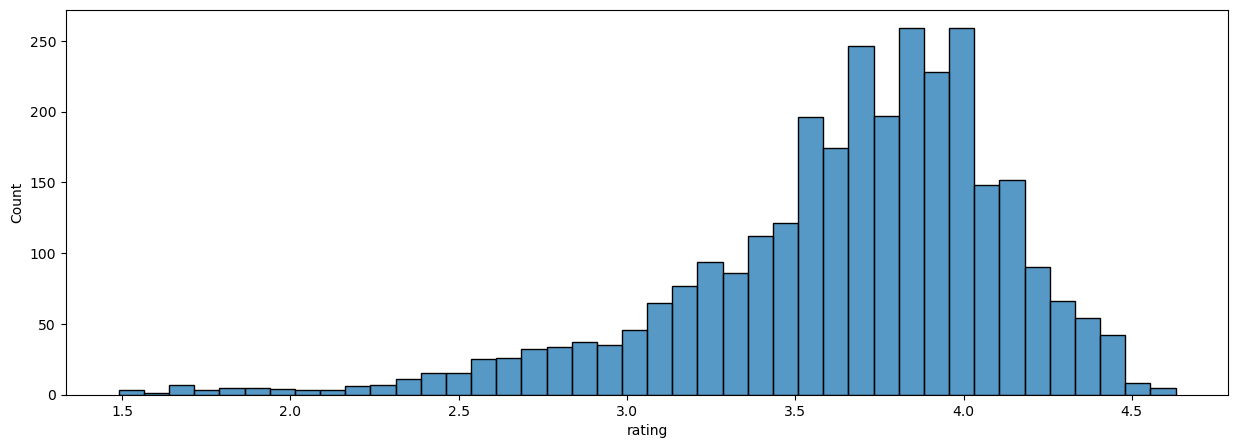

In [58]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_masters_ratings[df_masters_ratings['votes']>100], x='rating')

<Axes: xlabel='votes', ylabel='Count'>

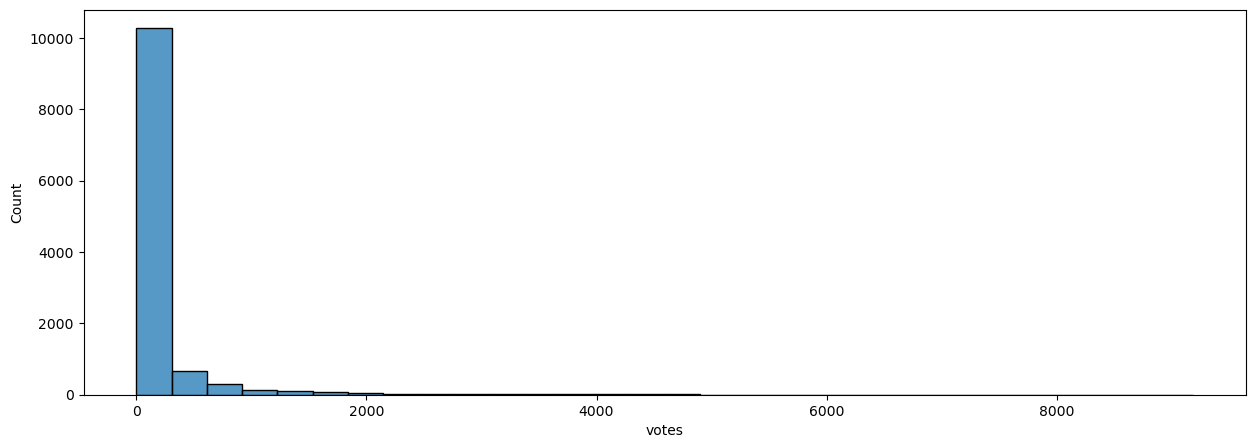

In [35]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_masters_ratings[df_masters_ratings['votes']>1], x='votes', bins=30)

<Axes: xlabel='count', ylabel='year'>

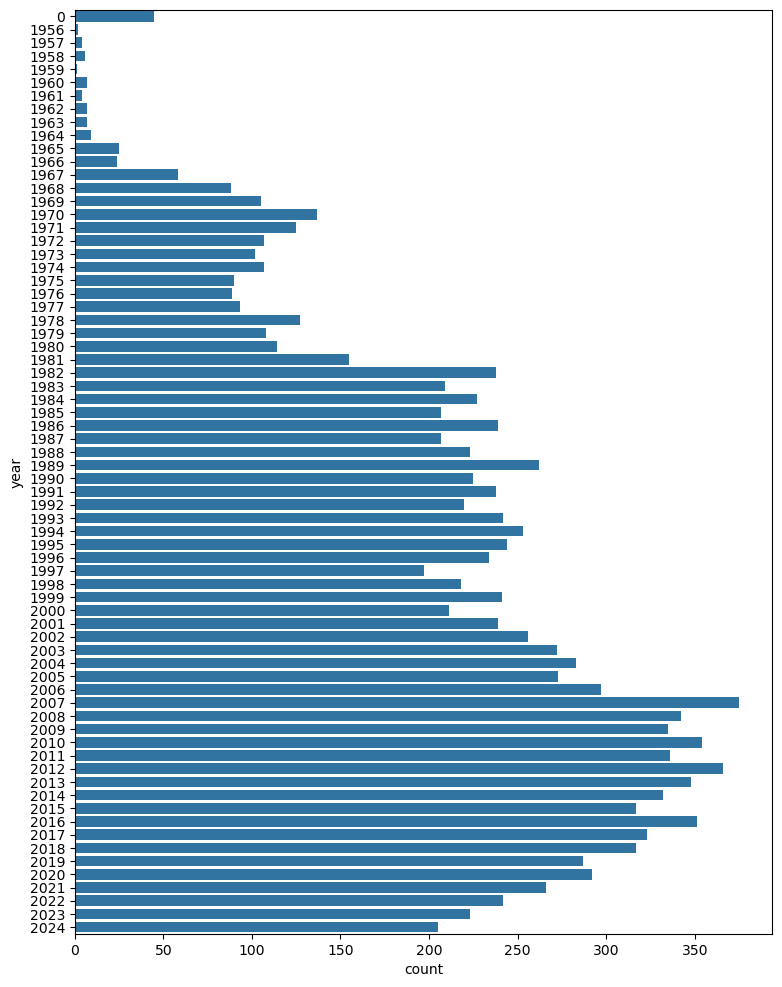

In [38]:
plt.figure(figsize=(9,12))
sns.countplot(data=df_masters_ratings, y='year')

# Merge with prog albums

In [ ]:
df_masters[df_masters['styles'].str.contains('Prog Rock')].shape

(3763, 13)

In [65]:
df_prog_artists = pd.read_csv('Datasets/df_prog_artists.csv')
df_prog_artists.shape

(12589, 4)

Since by default ``pd.merge`` is case-sensitive, I will create a temporary column with ``assign`` to merge the dataframes and then drop this temporary column and the one from ``df_prog_artists``, which I don't like because it's in uppercase

In [32]:
df_prog_ratings = pd.merge(
    df_ratings.assign(artist_lower=df_ratings['artist'].str.lower()), 
    df_prog_artists.assign(artist_lower=df_prog_artists['artist'].str.lower()), 
    on='artist_lower'
).drop(columns=['artist_lower', 'artist_y', 'href'])
# drop columns I don't need anymore

# rename columns
df_prog_ratings.rename(columns={'artist_x': 'artist'}, inplace=True)

# show the df
df_prog_ratings

,album_id,artist,title,rating,votes,style,country
0,41,Muse,Absolution,3.99,4411,Prog Related,United Kingdom
1,42,Muse,Showbiz,3.50,2181,Prog Related,United Kingdom
2,45,Finch,What It Is to Burn,3.69,864,Symphonic Prog,Netherlands
3,53,Dream Theater,Train of Thought,3.87,2670,Progressive Metal,United States
4,67,Black Sabbath,Paranoid,4.52,5144,Prog Related,United Kingdom
...,...,...,...,...,...,...,...
22142,516781,Buckethead,Castello Dwellers,4.50,1,Prog Related,United States
22143,516782,Buckethead,Signaling Across Time,4.00,1,Prog Related,United States
22144,516783,Buckethead,The Mines of Sigismund Fugger,4.00,1,Prog Related,United States
22145,516817,Jack O' The Clock,Portraits,4.00,1,Prog Folk,United States


In [66]:
df_prog_ratings[df_prog_ratings['votes']>10]

,album_id,artist,title,rating,votes,style,country
0,41,Muse,Absolution,3.99,4411,Prog Related,United Kingdom
1,42,Muse,Showbiz,3.50,2181,Prog Related,United Kingdom
2,45,Finch,What It Is to Burn,3.69,864,Symphonic Prog,Netherlands
3,53,Dream Theater,Train of Thought,3.87,2670,Progressive Metal,United States
4,67,Black Sabbath,Paranoid,4.52,5144,Prog Related,United Kingdom
...,...,...,...,...,...,...,...
22026,509781,Vylet Pony,Monarch of Monsters,3.77,13,Eclectic Prog,United States
22043,510543,Eidola,Mend,2.63,41,Experimental/Post Metal,United States
22046,510919,Ulver,Liminal Animals,3.26,73,Post Rock/Math rock,Norway
22137,516387,Obscura,A Sonication,2.75,48,Rock Progressivo Italiano,Italy


In [36]:
df_prog = pd.merge(df_prog_ratings, df_masters, on=['artist', 'title'])
df_prog

,album_id,artist,title,rating,votes,style,country,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,41,Muse,Absolution,3.99,4411,Prog Related,United Kingdom,1003,11052,7781939,Europe,2003,52.18,14,"['Album', 'Stereo']",['Rock'],['Alternative Rock'],"Muse are an English rock band from Teignmouth,..."
1,42,Muse,Showbiz,3.50,2181,Prog Related,United Kingdom,1003,11001,446060,UK,1999,49.65,12,"['Album', 'Stereo']",['Rock'],"['Alternative Rock', 'Prog Rock']","Muse are an English rock band from Teignmouth,..."
2,67,Black Sabbath,Paranoid,4.52,5144,Prog Related,United Kingdom,144998,302,696772,UK,1970,0.00,8,"['LP', 'Album']",['Rock'],"['Hard Rock', 'Heavy Metal']",Considered by many to be the first heavy metal...
3,70,Yes,Relayer,4.19,1114,Symphonic Prog,United Kingdom,50263,35126,4506926,UK,1974,40.47,3,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Yes are an English rock band who achieved worl...
4,77,Iron Maiden,Dance Of Death,3.59,2074,Prog Related,United Kingdom,251595,21512,8663555,Europe,2003,67.95,11,['Album'],['Rock'],['Heavy Metal'],"English heavy metal band formed in Leyton, Eas..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,502885,Hats Off Gentlemen It's Adequate,Nostalgia For Infinity,3.50,1,Crossover Prog,United Kingdom,6476937,2726864,15871538,UK,2020,47.98,8,"['Album', 'Stereo']",['Rock'],['Prog Rock'],NaN
1574,502886,Hats Off Gentlemen It's Adequate,The Confidence Trick,4.00,1,Crossover Prog,United Kingdom,6476937,2726867,23954783,UK,2022,68.12,13,"['Album', 'Stereo']",['Rock'],['Prog Rock'],NaN
1575,505233,Efterklang,Things We Have In Common,3.50,2,Post Rock/Math rock,Denmark,234846,3612478,31842014,"UK, Europe & US",2024,0.00,9,"['LP', 'Album']","['Electronic', 'Rock', 'Pop']","['Abstract', 'Indie Rock', 'Folk Rock']",Experimental indie/post-rock/orchestral band f...
1576,505271,Delta Sleep,Blue Garden,3.24,23,Crossover Prog,United Kingdom,3352599,3633390,32079486,US,2024,42.80,12,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Math Rock', 'Indie Rock']","Formed in 2008 as 'Sávlön' in Canterbury, UK, ..."


In [37]:
df_prog[df_prog['votes']>10]

,album_id,artist,title,rating,votes,style,country,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,41,Muse,Absolution,3.99,4411,Prog Related,United Kingdom,1003,11052,7781939,Europe,2003,52.18,14,"['Album', 'Stereo']",['Rock'],['Alternative Rock'],"Muse are an English rock band from Teignmouth,..."
1,42,Muse,Showbiz,3.50,2181,Prog Related,United Kingdom,1003,11001,446060,UK,1999,49.65,12,"['Album', 'Stereo']",['Rock'],"['Alternative Rock', 'Prog Rock']","Muse are an English rock band from Teignmouth,..."
2,67,Black Sabbath,Paranoid,4.52,5144,Prog Related,United Kingdom,144998,302,696772,UK,1970,0.00,8,"['LP', 'Album']",['Rock'],"['Hard Rock', 'Heavy Metal']",Considered by many to be the first heavy metal...
3,70,Yes,Relayer,4.19,1114,Symphonic Prog,United Kingdom,50263,35126,4506926,UK,1974,40.47,3,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Yes are an English rock band who achieved worl...
4,77,Iron Maiden,Dance Of Death,3.59,2074,Prog Related,United Kingdom,251595,21512,8663555,Europe,2003,67.95,11,['Album'],['Rock'],['Heavy Metal'],"English heavy metal band formed in Leyton, Eas..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,484810,Plantoid,Terrapath,3.59,19,Eclectic Prog,United Kingdom,13894711,3384352,29671858,UK,2024,39.25,10,"['LP', 'Album', 'Special Edition']","['Jazz', 'Rock']","['Prog Rock', 'Psychedelic Rock']",The band began as the brainchild of Chloe Spen...
1563,486448,Ihsahn,Ihsahn,3.81,193,Tech/Extreme Prog Metal,Norway,122289,3395569,29815420,NaN,2024,0.00,11,"['WAV', 'Album', 'Stereo']",['Rock'],"['Progressive Metal', 'Avantgarde']","Composer, singer and multi-instrumentalist fro..."
1566,490484,Dirty Three,Love Changes Everything,3.32,18,Post Rock/Math rock,Australia,65791,3517705,30983092,Australia & New Zealand,2024,41.33,6,"['LP', 'Album', 'Stereo']",['Rock'],['Post Rock'],Australian instrumental rock band founded duri...
1571,495923,Kingcrow,Hopium,3.49,20,Progressive Metal,Italy,1986621,3588815,31565200,"UK, Europe & US",2024,53.33,10,['Album'],['Rock'],"['Progressive Metal', 'Prog Rock']",Kingcrow are an Italian band born in Anguillar...


In [38]:
df_prog[df_prog['votes']>10].artist.nunique()

351

# Concat with the previous ``df_master_id_0``

In [7]:
df_masters_id0_2003 = pd.read_csv('Datasets/df_masters_id0_2003.csv')
df_masters_id0_2003.shape

(850, 13)

In [15]:
df_masters_id0_2003.year.value_counts()

year
2003    850
Name: count, dtype: int64

In [4]:
df_masters_id0 = pd.read_csv('Datasets/df_masters_id0.csv')
df_masters_id0.shape

(844, 13)

In [5]:
df_masters_id0.year.value_counts()

year
2004    791
2024     21
2002     12
2000      9
2003      7
2001      4
Name: count, dtype: int64

In [18]:
df_masters_id0_concat = pd.concat([df_masters_id0_2001, df_masters_id0_2002, df_masters_id0_2003])
df_masters_id0_concat.shape

(2329, 13)

In [19]:
df_masters_id0_concat.year.value_counts()

year
2003    850
2002    778
2001    701
Name: count, dtype: int64

# ``df_id0_ratings`` cleaning

## Dropping duplicated albums

In [29]:
# check if there are duplicates
df_id0_ratings.duplicated().sum()

2

In [30]:
# drop duplicates
df_id0_ratings.drop_duplicates(subset=['artist', 'title'], inplace=True)
df_id0_ratings.shape[0]

26

**Dropping live albums, compilations...**

In [31]:
# drop compilations
df_id0_ratings = df_id0_ratings[~df_id0_ratings['release_type'].str.contains('Compilation')]
df_id0_ratings.shape[0]

26

In [34]:
df_id0_ratings.sort_values(['votes', 'title', 'artist'], ascending=False)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
10,1758,Counting Crows,Hard Candy,3.35,138,262643.0,NaN,30989143,UK,2002,0.00,15,"['Album', 'Unofficial Release']",['Rock'],"['Southern Rock', 'Alternative Rock']",Counting Crows is an American rock band from B...
44,123688,The Little Explorer,The Little Explorer,3.80,27,1100295.0,NaN,2747168,UK,2003,0.00,8,['Album'],['Rock'],['Emo'],NaN
38,79784,Tygers Of Pan Tang,Mystical,2.30,10,407694.0,NaN,4632749,UK,2001,49.37,11,['Album'],['Rock'],"['Heavy Metal', 'Hard Rock']",British Heavy Metal band from Whitley Bay form...
12,6347,Howards Alias,The Chameleon Script,4.11,9,918301.0,NaN,1393346,UK,2002,37.03,11,['Album'],['Rock'],"['Ska', 'Punk', 'Indie Rock']","Band in the modern UK underground punk scene, ..."
17,17416,The String Cheese Incident,Untying The Not,3.43,7,246185.0,NaN,32414148,UK & Europe,2003,54.35,13,['Album'],"['Jazz', 'Rock', 'Folk, World, & Country']","['Bluegrass', 'Alternative Rock', 'Jazz-Rock',...",The String Cheese Incident (SCI) is an America...
28,34630,Darkflight,Under The Shadow Of Fear,3.17,6,334729.0,NaN,1301861,UK,2003,40.35,8,['Album'],['Rock'],"['Black Metal', 'Doom Metal']","Atmospheric black/doom metal duo from Varna, B..."
34,61038,Sputniks Down,Much Was Decided Before You Were Born,2.08,6,43018.0,NaN,594879,UK,2001,47.18,7,['Album'],"['Electronic', 'Rock']",['Post Rock'],"Sputniks Down were a Scottish band, made up of..."
8,1651,Miocene,Cellular Memory,3.75,6,958779.0,NaN,1809183,UK,2002,40.60,6,['Album'],['Rock'],[],"Forming in 1998, but consolidating their line-..."
52,188309,Karnataka,Delicate Flame Of Desire,3.80,5,1420825.0,NaN,1726424,UK,2003,61.50,9,['Album'],['Rock'],"['Folk Rock', 'Prog Rock']","Progressive Rock band from Swansea, Wales, UK"
35,61942,Fallen To,The Mark,2.67,3,1198317.0,NaN,3005917,UK,2002,43.80,11,['Album'],['Rock'],['Nu Metal'],NaN


In [35]:
# check one by one if necessary
try:
    df_id0_ratings.drop([49, 50, 51], axis=0, inplace=True)
    print('Rows dropped')
    print(df_id0_ratings.shape)
except:
    print("Couldn't drop these rows")
    print(df_id0_ratings.shape)

Rows dropped
(23, 16)


## Concat with the previous ``df_master_id_0``

In [36]:
df_masters_id0 = pd.read_csv('Datasets/df_masters_id0.csv')
df_masters_id0.shape

(30, 16)

In [37]:
df_masters_id0_concat = pd.concat([df_masters_id0, df_id0_ratings])
df_masters_id0_concat.shape

(53, 16)

## **Export to csv**

In [49]:
df_masters.to_csv('Datasets/df_masters.csv', index=False)

In [40]:
df_masters_id0_concat.to_csv('Datasets/df_masters_id0.csv', index=False)

In [3]:
df_masters_id0 = pd.read_csv('Datasets/df_masters_id0.csv')
df_masters_id0.shape

(30, 16)

In [4]:
df_masters_id0

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,498666,Blasfeme,Black Legion,3.59,33,8287884.0,NaN,32987169,UK,2024,32.33,7,"['Album', 'Limited Edition']",['Rock'],['Black Metal'],"Blasfeme is a two piece black metal force, fue..."
1,507340,Dawnwalker,The Unknowing,3.68,11,7622357.0,NaN,32331393,UK,2024,0.00,9,"['LP', 'Album']",['Rock'],['Prog Rock'],"Post-Metal/Rock band from London, UK."
2,504016,Trash Boat,Heaven Can Wait,2.64,11,3896679.0,NaN,32921493,UK,2024,36.03,11,"['12""', '33 ⅓ RPM', 'Album', 'Stereo']",['Rock'],['Hardcore'],NaN
3,512234,Caelestra,Bastion,3.95,10,8367186.0,NaN,32682639,UK,2024,48.65,6,['Album'],['Rock'],"['Progressive Metal', 'Post-Metal', 'Black Met...","Caelestra. Bristol, UK. The creation of Fever ..."
4,496271,Other Half,Dark Ageism,3.64,5,4456943.0,NaN,31040566,UK,2024,0.00,12,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Post-Hardcore', 'Punk']",NaN
5,490535,Ildganger,For Hver Tanke Mister Sj​æ​len Atter Farve,3.62,4,12767564.0,NaN,30251867,UK,2024,0.00,5,"['LP', 'Album', 'Limited Edition']",['Rock'],['Black Metal'],"Black Metal project from Aarhus, Denmark."
6,496009,Gnod,Spot Land,3.12,4,1107254.0,NaN,30624286,UK,2024,0.00,5,"['LP', 'Album', 'Limited Edition']","['Electronic', 'Rock']","['Alternative Rock', 'Industrial', 'Drone', 'M...","Gnod are a British rock band from Salford, Gre..."
7,487309,Ilat Mahru,Incipit Akkadian,3.50,3,12679967.0,NaN,30173384,UK,2024,34.33,4,"['Mini-Album', 'Limited Edition']",['Rock'],['Black Metal'],NaN
8,492912,Perseus,Into The Silence,3.50,3,220153.0,NaN,30422189,UK,2024,44.37,11,"['Album', 'Limited Edition']",['Rock'],"['Heavy Metal', 'Power Metal']",Heavy/power metal band from Italy
9,505338,Thank,I Have A Physical Body That Can Be Harmed,3.75,2,6092482.0,NaN,32117175,UK,2024,0.00,10,"['LP', 'Album']","['Hip Hop', 'Rock']","['Noise Rock', 'Post-Punk', 'No Wave']",Noise rock / post-punk / no wave band from Lee...


# ``df_masters`` cleaning

In [16]:
df_masters[df_masters[['artist', 'title']].duplicated()]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
87,252121,NaN,11119495,UK,Judas Priest,Screaming For Vengeance,1982,38.28,10,"['LP', 'Album']",['Rock'],['Heavy Metal'],British Heavy Metal band preceding the ‘New Wa...
255,446450,NaN,2035504,UK,The Del-Byzanteens,Lies To Live By,1982,31.15,7,"['LP', 'Album']",['Rock'],"['New Wave', 'Avantgarde']","American group based in New York, featuring fl..."
258,130830,NaN,5604035,UK,Felt,Crumbling The Antiseptic Beauty,1982,0.00,6,"['LP', 'Album']",['Rock'],"['Alternative Rock', 'Ethereal']","English indie pop band from Water Orton, Warwi..."
297,161785,NaN,13695605,UK,Theatre Of Hate,Westworld,1982,0.00,10,"['LP', 'Album']",['Rock'],['Goth Rock'],Theatre of Hate are a British post-punk band w...
304,251595,NaN,17855461,UK,Iron Maiden,The Number Of The Beast,1982,39.18,8,"['LP', 'Album', 'Stereo']",['Rock'],['Heavy Metal'],"English heavy metal band formed in Leyton, Eas..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43861,4637602,1510124.0,13288778,Europe,A Mote Of Dust,A Mote Of Dust,2019,0.00,10,"['LP', 'Album', 'Limited Edition']",['Rock'],"['Post Rock', 'Folk Rock']","Solo project of Craig b (Aereogramme, The Unw..."
43887,159169,81033.0,378703,US,Jeff Buckley,Live At Sin-é,2003,160.95,38,[],['Rock'],"['Alternative Rock', 'Folk Rock']","Jeffrey Scott Buckley (November 17, 1966 - May..."
44015,50263,555721.0,10747602,US,Yes,Yessongs,1984,70.00,1,"['Stereo', 'NTSC']",['Rock'],['Prog Rock'],Yes are an English rock band who achieved worl...
44050,218108,16135.0,861751,Europe,Marillion,Brave,1994,71.03,11,['Album'],['Rock'],"['Classic Rock', 'Prog Rock', 'Symphonic Rock']","Marillion formed in Aylesbury, Buckinghamshire..."


In [15]:
df_masters.shape

(45374, 13)

In [47]:
df_masters[df_masters['artist']=="Kingston Wall"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [ ]:
# check one by one if necessary
try:
    df_id0_ratings.drop([49, 50, 51], axis=0, inplace=True)
    print('Rows dropped')
    print(df_id0_ratings.shape)
except:
    print("Couldn't drop these rows")
    print(df_id0_ratings.shape)

In [44]:
artist = "Kingston Wall"

df_ratings[df_ratings['artist']==artist]

,album_id,artist,title,rating,votes
11887,15257,Kingston Wall,Kingston Wall II,4.23,90
15401,19434,Kingston Wall,Kingston Wall I,4.11,51
23213,28724,Kingston Wall,III - Tri-Logy,3.94,45
137350,174775,Kingston Wall,Freakout Remixes,3.00,1
